In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
bookings = pd.read_csv("../data/interim/booking_log.csv")
participants = pd.read_csv("../data/interim/participant_log.csv")
data_set = pd.read_csv("../data/processed/dataset.csv")

In [5]:
participants.head()

,driver_id,participant_status,order_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy,date,time,timestamp
0,110283102582,CREATED,938125906616,309579604593,-2.981389,104.761898,2.0,2015-05-18,11:45:19.519,2015-05-18 11:45:19.519
1,110283102582,ACCEPTED,938125906616,309579604593,-2.981389,104.761898,2.0,2015-05-18,11:45:29.8,2015-05-18 11:45:29.800
2,126346998414,CREATED,992080359113,941995970460,-2.966915,104.748040,2.0,2015-05-11,10:35:57.021,2015-05-11 10:35:57.021
3,126346998414,ACCEPTED,992080359113,941995970460,-2.966915,104.748040,2.0,2015-05-11,10:36:01.148,2015-05-11 10:36:01.148
4,199325048812,ACCEPTED,797723880713,197604093364,-3.014740,104.694647,2.0,2015-05-16,12:34:20.044,2015-05-16 12:34:20.044


In [4]:
participants['participant_status'].unique()

array(['CREATED', 'ACCEPTED', 'IGNORED', 'REJECTED'], dtype=object)

In [14]:
group_participants = participants.sort_values(['driver_id', 'order_id', 'timestamp']).groupby(['driver_id', 'order_id'])


In [7]:
data_set['timestamp'] = pd.to_datetime(data_set['timestamp'])


In [ ]:
def _duration(df, start, end, name):

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['time_diff'] = df.sort_values(['order_id', 'timestamp']).groupby('order_id')[
        'timestamp'].diff()
    g = df.groupby('order_id')
    duration = g.apply(lambda x: sum(x[x['booking_status'] == start]['time_diff'], x[
                       x['booking_status'] == end]['time_diff']) / np.timedelta64(1, 'm'))
    duration_df = duration.reset_index()
    df = df.merge(duration_df, on='order_id')
    df.drop(['level_1'], axis=1, inplace=True)
    df.rename(columns={"time_diff_y": name}, inplace=True)
    return df

def compute_distances(d_lat, d_lng, p_lat, p_lng):
    rad_lat, rad_lng, rad_pt_lat, rad_pt_lng = map(
        np.radians, [d_lat, d_lng, p_lat, p_lng]
    )
    dlng = rad_lng - rad_pt_lng
    dlat = rad_lat - rad_pt_lat
    a = np.sin(dlat / 2.0) ** 2 + np.cos(rad_lat) * np.cos(rad_pt_lat) \
        * np.sin(dlng / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return c

In [117]:
dataset = _duration(dataset, 'PICKED_UP', 'COMPLETED', 'mean_dropoff')

In [110]:
new_data_set = data_set.merge(dataset[['order_id', 'mean_dropoff']], on = 'order_id')

In [112]:
dedup = new_data_set.drop_duplicates(['order_id', 'driver_id_pnt'])

In [126]:
dedup['travel_dist'] = compute_distances(dedup['pickup_latitude'], dedup['pickup_longitude'],\
                                                        dedup['driver_latitude'], dedup['driver_longitude'])

/Users/estherdawes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [135]:
dedup['travel_time'] = dedup['mean_dropoff']

/Users/estherdawes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [137]:
dedup['average_speed'] = 1000 * dedup['trip_distance']/dedup['travel_time']

/Users/estherdawes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [139]:
dedup['pickup_weekday'] = dedup['timestamp'].dt.weekday
dedup['pickup_hour_weekofyear'] = dedup['timestamp'].dt.weekofyear
dedup['pickup_hour'] = dedup['timestamp'].dt.hour
dedup['pickup_minute'] = dedup['timestamp'].dt.minute

/Users/estherdawes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/estherdawes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/estherdawes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

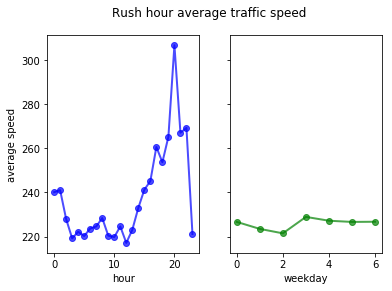

In [145]:
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].plot(dedup.groupby('pickup_hour').mean()['average_speed'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(dedup.groupby('pickup_weekday').mean()['average_speed'], 'go-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()